# EDA

In [97]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import os
def readSentences(path):
    sentences = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                print(os.path.join(root, file))
                with open(os.path.join(root, file), "r") as input:
                    sen = input.read().replace('?','.').replace('!','.').replace('\n','.')
                    sen = sen.split(".")   #. denotes end of sentence
                sentences.extend(sen)
    return sentences
mao_sentences = readSentences("../mao")
print(len(mao_sentences))
print(mao_sentences[0])

../mao/REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
../mao/WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
../mao/ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
../mao/ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
../mao/A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
../mao/BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
1702
THE IMPORTANCE OF THE PEASANT PROBLEM


In [11]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

,Sentence
0,THE IMPORTANCE OF THE PEASANT PROBLEM
1,During my recent visit to Hunan [1] I made a f...
2,In the thirty-two days from January 4 to Febr...
3,Many of the hows and whys of the peasant move...
4,I saw and heard of many strange things of whi...


In [12]:
mao_df['NumWords'] = mao_df['Sentence'].apply(lambda x: len(x.split()))

In [13]:
mao_df["author"] = 'mao'
mao_df.head()

,Sentence,NumWords,author
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,mao
1,During my recent visit to Hunan [1] I made a f...,25,mao
2,In the thirty-two days from January 4 to Febr...,48,mao
3,Many of the hows and whys of the peasant move...,24,mao
4,I saw and heard of many strange things of whi...,15,mao


Let's do some cleaning operations like turning all words to lowercase, remove punctuation and non-ASCII characters which are irrelevant for modeling topics.

In [14]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [15]:
mao_df.head()

,Sentence,NumWords,author,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,mao,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,mao,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,mao,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,mao,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,mao,saw and heard many strange things which had hi...


Remove short sentence

In [16]:
mao_df = mao_df[mao_df.NumWords>0]
short_sentence = mao_df[mao_df.NumWords<5]
short_sentence

,Sentence,NumWords,author,Sentence2
14,There are three alternatives,4,mao,there are three alternatives
21,GET ORGANIZED,2,mao,get organized
53,"""Here's ten yuan",3,mao,here ten yuan
57,"""Ugh",1,mao,ugh
59,""" the peasants reply",4,mao,the peasants reply
...,...,...,...,...
1655,Not in the least,4,mao,not the least
1659,"No, nothing",2,mao,nothing
1660,His bastions of iron,4,mao,his bastions iron
1661,They all crumbled,3,mao,they all crumbled


In [17]:
mao_df = mao_df[mao_df.NumWords>=5]
mao_df = mao_df.reset_index(drop=True)
mao_df

,Sentence,NumWords,author,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,mao,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,mao,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,mao,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,mao,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,mao,saw and heard many strange things which had hi...
...,...,...,...,...
1167,All revolutionary cadres have a tremendous re...,7,mao,all revolutionary cadres have tremendous respo...
1168,After this congress we must adopt effective m...,30,mao,after this congress must adopt effective measu...
1169,We must create thousands of townships like Ch...,14,mao,must create thousands townships like changkang...
1170,They will be our strongholds,5,mao,they will our strongholds


do data cleaning for other corpus

In [21]:
def preprocessing(path, author):
    sentences = readSentences(path)
    df = pd.DataFrame(sentences, columns = ['Sentence'])
    df['NumWords'] = df['Sentence'].apply(lambda x: len(x.split()))
    df["author"] = author
    df['Sentence2'] = df['Sentence'].apply(normalize_texts)
    df['Sentence2'] = df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    df = df[df.NumWords>=5]
    df = df.reset_index(drop=True)
    return df

In [27]:
franklin_df = preprocessing("corpus/Franklin", 'franklin')
franklin_df

corpus/Franklin/Autobiography of Benjamin Franklin.txt


,Sentence,NumWords,author,Sentence2
0,Project\tGutenberg's\tAutobiography\tof\tBenja...,23,franklin,project gutenberg autobiography benjamin frank...
1,"\t\tYou\tmay\tcopy\tit,\tgive\tit\taway\tor",8,franklin,you may copy give away
2,re-use\tit\tunder\tthe\tterms\tof\tthe\tProjec...,11,franklin,use under the terms the project gutenberg lice...
3,with\tthis\teBook\tor\tonline\tat\twww,7,franklin,with this ebook online www
4,Title:\tAutobiography\tof\tBenjamin\tFranklin,5,franklin,title autobiography benjamin franklin
...,...,...,...,...
4881,XIV ALBANY PLAN OF UNION,5,franklin,xiv albany plan union
4882,XV QUARRELS WITH THE PROPRIETARY GOVERNORS,6,franklin,quarrels with the proprietary governors
4883,XVII FRANKLIN'S DEFENSE OF THE FRONTIER,6,franklin,xvii franklin defense the frontier
4884,XIX AGENT OF PENNSYLVANIA IN LONDON,6,franklin,xix agent pennsylvania london


In [46]:
keller_df = preprocessing("corpus/Helen Keller", 'Helen Keller')
keller_df

corpus/Helen Keller/The Story of My Life.txt


,Sentence,NumWords,author,Sentence2
0,"Project Gutenberg’s etext, Story of My Life, b...",32,Helen Keller,project gutenberg etext story life helen kelle...
1,Please take a look at the important informatio...,11,Helen Keller,please take look the important information thi...
2,We encourage you to keep this file on your own...,20,Helen Keller,encourage you keep this file your own disk kee...
3,**Welcome To The World of Free Plain Vanilla E...,10,Helen Keller,welcome the world free plain vanilla electroni...
4,**Etexts Readable By Both Humans and By Comput...,10,Helen Keller,etexts readable both humans and computers since
...,...,...,...,...
6749,What if a ray of light should flash through t...,15,Helen Keller,what ray light should flash through the darken...
6750,"What would happen, I ask many and many a time",10,Helen Keller,what would happen ask many and many time
6751,Would the bow-and-string tension of life snap,7,Helen Keller,would the bow and string tension life snap
6752,"Would the heart, overweighted with sudden joy...",14,Helen Keller,would the heart overweighted with sudden joy s...


In [25]:
timemachine_df = preprocessing("corpus/science fiction", 'George Wells')
timemachine_df.head()

corpus/science fiction/timemachine.txt


,Sentence,NumWords,author,Sentence2
0,The Time Traveller (for so it will be convenie...,13,George Wells,the time traveller for will convenient speak him
1,was expounding a recondite matter to us,7,George Wells,was expounding recondite matter
2,His grey eyes shone and,5,George Wells,his grey eyes shone and
3,"twinkled, and his usually pale face was flushe...",10,George Wells,twinkled and his usually pale face was flushed...
4,"fire burned brightly, and the soft radiance of...",10,George Wells,fire burned brightly and the soft radiance the...


In [47]:
keller_df.Sentence[90:100]

90       If you don’t derive profits, no royalty is due
91     Royalties are payable to “Project Gutenberg A...
92    WHAT IF YOU WANT TO SEND MONEY EVEN IF YOU DON...
93    The Project gratefully accepts contributions i...
94     Money should be paid to “Project Gutenberg As...
95                                 THE STORY OF MY LIFE
96    AND A SUPPLEMENTARY ACCOUNT OF HER EDUCATION, ...
97              OF HER TEACHER, ANNE MANSFIELD SULLIVAN
98       CONTAINING ADDITIONAL CHAPTERS BY HELEN KELLER
99                     Who has taught the deaf to speak
Name: Sentence, dtype: object

In [48]:
keller_df = keller_df[95:]
keller_df = keller_df.reset_index(drop=True)
keller_df = keller_df[:6658]
keller_df

,Sentence,NumWords,author,Sentence2
0,THE STORY OF MY LIFE,5,Helen Keller,the story life
1,"AND A SUPPLEMENTARY ACCOUNT OF HER EDUCATION, ...",14,Helen Keller,and supplementary account her education includ...
2,"OF HER TEACHER, ANNE MANSFIELD SULLIVAN",6,Helen Keller,her teacher anne mansfield sullivan
3,CONTAINING ADDITIONAL CHAPTERS BY HELEN KELLER,6,Helen Keller,containing additional chapters helen keller
4,Who has taught the deaf to speak,7,Helen Keller,who has taught the deaf speak
...,...,...,...,...
6653,What if in my waking hours a sound should rin...,16,Helen Keller,what waking hours sound should ring through th...
6654,What if a ray of light should flash through t...,15,Helen Keller,what ray light should flash through the darken...
6655,"What would happen, I ask many and many a time",10,Helen Keller,what would happen ask many and many time
6656,Would the bow-and-string tension of life snap,7,Helen Keller,would the bow and string tension life snap


In [53]:
franklin_df = franklin_df[95:]
franklin_df = franklin_df.reset_index(drop=True)
franklin_df = franklin_df[:4000]
franklin_df

,Sentence,NumWords,author,Sentence2
0,and\tin\testablishing\tit\tas\ta\tnation,7,franklin,and establishing nation
1,\tFranklin\tshares\twith\tWashington\tthe\thon...,7,franklin,franklin shares with washington the honors
2,"the\tRevolution,\tand\tof\tthe\tevents\tleadin...",14,franklin,the revolution and the events leading the birt...
3,Washington\twas\tthe\tanimating\tspirit\tof\tt...,13,franklin,washington was the animating spirit the strugg...
4,\t To\t Franklin's\t cogent\t reasoning\t and\...,48,franklin,franklin cogent reasoning and keen satire owe ...
...,...,...,...,...
3995,\t I\t put\t my\t letters\t into\t his\t hands...,10,franklin,put letters into his hands the same day
3996,\t A fortnight\t after\t I\t met\t him\t again...,11,franklin,fortnight after met him again the same place
3997,"\t ""So,\t you\t are\t soon\t return'd, Innis",6,franklin,you are soon return innis
3998,"\t no,\t I\t am\t not\t gone\t yet",6,franklin,not gone yet


In [54]:
mao_df

,Sentence,NumWords,author,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,mao,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,mao,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,mao,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,mao,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,mao,saw and heard many strange things which had hi...
...,...,...,...,...
1167,All revolutionary cadres have a tremendous re...,7,mao,all revolutionary cadres have tremendous respo...
1168,After this congress we must adopt effective m...,30,mao,after this congress must adopt effective measu...
1169,We must create thousands of townships like Ch...,14,mao,must create thousands townships like changkang...
1170,They will be our strongholds,5,mao,they will our strongholds


In [55]:
keller_df

,Sentence,NumWords,author,Sentence2
0,THE STORY OF MY LIFE,5,Helen Keller,the story life
1,"AND A SUPPLEMENTARY ACCOUNT OF HER EDUCATION, ...",14,Helen Keller,and supplementary account her education includ...
2,"OF HER TEACHER, ANNE MANSFIELD SULLIVAN",6,Helen Keller,her teacher anne mansfield sullivan
3,CONTAINING ADDITIONAL CHAPTERS BY HELEN KELLER,6,Helen Keller,containing additional chapters helen keller
4,Who has taught the deaf to speak,7,Helen Keller,who has taught the deaf speak
...,...,...,...,...
6653,What if in my waking hours a sound should rin...,16,Helen Keller,what waking hours sound should ring through th...
6654,What if a ray of light should flash through t...,15,Helen Keller,what ray light should flash through the darken...
6655,"What would happen, I ask many and many a time",10,Helen Keller,what would happen ask many and many time
6656,Would the bow-and-string tension of life snap,7,Helen Keller,would the bow and string tension life snap


In [56]:
franklin_df

,Sentence,NumWords,author,Sentence2
0,and\tin\testablishing\tit\tas\ta\tnation,7,franklin,and establishing nation
1,\tFranklin\tshares\twith\tWashington\tthe\thon...,7,franklin,franklin shares with washington the honors
2,"the\tRevolution,\tand\tof\tthe\tevents\tleadin...",14,franklin,the revolution and the events leading the birt...
3,Washington\twas\tthe\tanimating\tspirit\tof\tt...,13,franklin,washington was the animating spirit the strugg...
4,\t To\t Franklin's\t cogent\t reasoning\t and\...,48,franklin,franklin cogent reasoning and keen satire owe ...
...,...,...,...,...
3995,\t I\t put\t my\t letters\t into\t his\t hands...,10,franklin,put letters into his hands the same day
3996,\t A fortnight\t after\t I\t met\t him\t again...,11,franklin,fortnight after met him again the same place
3997,"\t ""So,\t you\t are\t soon\t return'd, Innis",6,franklin,you are soon return innis
3998,"\t no,\t I\t am\t not\t gone\t yet",6,franklin,not gone yet


In [57]:
timemachine_df

,Sentence,NumWords,author,Sentence2
0,The Time Traveller (for so it will be convenie...,13,George Wells,the time traveller for will convenient speak him
1,was expounding a recondite matter to us,7,George Wells,was expounding recondite matter
2,His grey eyes shone and,5,George Wells,his grey eyes shone and
3,"twinkled, and his usually pale face was flushe...",10,George Wells,twinkled and his usually pale face was flushed...
4,"fire burned brightly, and the soft radiance of...",10,George Wells,fire burned brightly and the soft radiance the...
...,...,...,...,...
3366,...,14,George Wells,most people start our web site which has the m...
3367,...,8,George Wells,this web site includes information about proje...
3368,...,10,George Wells,including how make donations the project guten...
3369,...,12,George Wells,archive foundation how help produce our new eb...


In [58]:
df = pd.DataFrame(columns = ['Sentence','NumWords','author','Sentence2'])

In [60]:
mao_df = mao_df.sample(1000,random_state=1)
franklin_df = franklin_df.sample(1000,random_state=1)
keller_df = keller_df.sample(1000,random_state=1)
timemachine_df = timemachine_df.sample(1000,random_state=1)

In [66]:
df = df.append(mao_df)
df = df.append(franklin_df)
df = df.append(keller_df)
df = df.append(timemachine_df)
df = df.reset_index(drop=True)
df

,Sentence,NumWords,author,Sentence2
0,"Because of the pressure of foreign goods, the...",40,mao,because the pressure foreign goods the exhaust...
1,"You have worshipped them for centuries, and t...",23,mao,you have worshipped them for centuries and the...
2,In Changkang when fire broke out in a poor pe...,30,mao,changkang when fire broke out poor peasant hou...
3,The second question concerns our methods of work,8,mao,the second question concerns our methods work
4,The peasants are very enthusiastic about thes...,17,mao,the peasants are very enthusiastic about these...
...,...,...,...,...
3995,watching with a strange fascination the sun gr...,11,George Wells,watching with strange fascination the sun grow...
3996,'In another moment we were standing face to fa...,13,George Wells,another moment were standing face face and thi...
3997,"And therewith, taking the lamp in his hand, h...",11,George Wells,and therewith taking the lamp his hand led the
3998,"White Sphinx, was a meek surrender",6,George Wells,white sphinx was meek surrender


# Sentence Embedding

In [67]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('stsb-roberta-large')

In [69]:
sentence_embeddings = model.encode(df.Sentence2)
sentence_embeddings.shape

(4000, 1024)

# Kmeans

Try to find the best k, let us use `Silhouette Coefficient`

Silhouette Coefficient    
https://en.wikipedia.org/wiki/Silhouette_(clustering)   

-1<=Si<=1   
The clusting performance is better when the Silhouette Coefficient is close to 1

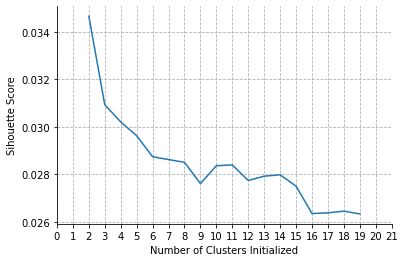

In [70]:
from sklearn import metrics
from sklearn.cluster import KMeans

scores = []
for k in range(2,20):
    labels = KMeans(n_clusters=k).fit(sentence_embeddings).labels_
    score = metrics.silhouette_score(sentence_embeddings, labels)
    scores.append(score)

plt.plot(list(range(2,20)),scores)
plt.xticks(range(0,22,1)) 
plt.grid(linestyle='--')
plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Sihouette Score")
sns.despine()

## 8 cluster Kmeans

In [71]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=8, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(sentence_embeddings)
cluster_df = pd.DataFrame({'sentence2':df.Sentence2,'author': df.author,'topic_cluster': y_km })

In [72]:
cluster_df

,sentence2,author,topic_cluster
0,because the pressure foreign goods the exhaust...,mao,2
1,you have worshipped them for centuries and the...,mao,6
2,changkang when fire broke out poor peasant hou...,mao,2
3,the second question concerns our methods work,mao,3
4,the peasants are very enthusiastic about these...,mao,0
...,...,...,...
3995,watching with strange fascination the sun grow...,George Wells,7
3996,another moment were standing face face and thi...,George Wells,4
3997,and therewith taking the lamp his hand led the,George Wells,1
3998,white sphinx was meek surrender,George Wells,1


In [73]:
cluster_df.loc[cluster_df['topic_cluster'] == 0].head()

,sentence2,author,topic_cluster
4,the peasants are very enthusiastic about these...,mao,0
11,the masses the millions upon millions people w...,mao,0
36,that why they are particularly good fighters,mao,0
78,the five wells mountain area the juncture yung...,mao,0
88,and their ancestral graves have suddenly start...,mao,0


In [74]:
cluster_df.loc[cluster_df['topic_cluster'] == 1].head()

,sentence2,author,topic_cluster
10,some counties called the joint council public ...,mao,1
12,they say put their names down the other register,mao,1
14,what currently called reduction interest confi...,mao,1
23,now they have found weapon which none other th...,mao,1
27,present the political situation such counties ...,mao,1


In [75]:
cluster_df.loc[cluster_df['topic_cluster'] == 2].head()

,sentence2,author,topic_cluster
0,because the pressure foreign goods the exhaust...,mao,2
2,changkang when fire broke out poor peasant hou...,mao,2
5,long live the peasant associations,mao,2
8,true the poor peasants are not afraid losing a...,mao,2
13,there are three kinds peasants the rich the mi...,mao,2


In [76]:
cluster_df.loc[cluster_df['topic_cluster'] == 3].head()

,sentence2,author,topic_cluster
3,the second question concerns our methods work,mao,3
7,should discuss them adopt and carry out decisi...,mao,3
28,this general principle,mao,3
45,once decision reached must firmly carried out,mao,3
51,such are the tactics have used for the past th...,mao,3


In [77]:
cluster_df.loc[cluster_df['topic_cluster'] == 4].head()

,sentence2,author,topic_cluster
6,this what some people call going too far excee...,mao,4
15,therefore would wrong abandon the struggle the...,mao,4
16,the question whether there will soon revolutio...,mao,4
34,the central committee letter dated february ma...,mao,4
42,first militarily the enemy weakest there,mao,4


In [78]:
cluster_df.loc[cluster_df['topic_cluster'] == 5].head()

,sentence2,author,topic_cluster
31,whom can get teach them,mao,5
33,there are two questions which comrades have fa...,mao,5
58,look you can even pass water without bumping i...,mao,5
96,before long tens thousands schools will have s...,mao,5
128,chance you get into intimate conversation with...,mao,5


In [79]:
cluster_df.loc[cluster_df['topic_cluster'] == 6].head()

,sentence2,author,topic_cluster
1,you have worshipped them for centuries and the...,mao,6
9,but fighting among the warlords does not every...,mao,6
19,some comrades consider only the interests thei...,mao,6
49,thus the county judicial assistant simply has ...,mao,6
69,was necessary forbid malicious criticism the p...,mao,6


In [80]:
cluster_df.loc[cluster_df['topic_cluster'] == 7].head()

,sentence2,author,topic_cluster
20,the question going too far,mao,7
55,they ought replaced,mao,7
73,actually however this decrease only temporary ...,mao,7
75,never heard such thing before yet managed live...,mao,7
87,this unrealistic view,mao,7


In [81]:
centers = km.cluster_centers_
centers

array([[-0.3571515 ,  0.33017132, -0.6446519 , ...,  0.5847516 ,
        -0.9719579 ,  0.489548  ],
       [ 0.02717333,  0.3126027 , -0.34625673, ..., -0.10555848,
        -0.57918644,  0.28645885],
       [-0.05469429,  0.6501019 ,  0.04033604, ...,  0.73415816,
        -0.93261063,  0.34374738],
       ...,
       [ 0.14241868,  0.33698323, -0.25719625, ...,  0.02942052,
        -1.132851  ,  1.0686945 ],
       [-0.02335586, -0.06772247, -0.47354248, ..., -0.00642964,
        -0.16102207,  0.62151706],
       [ 0.00763638,  0.42811155, -0.07136668, ...,  0.13777077,
        -0.44864243,  0.6899041 ]], dtype=float32)

Select a sentence which is cloest to each group center

In [82]:
def select_center_sentence(group_id):
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = sentence_embeddings[cluster_df['topic_cluster'] == group_id]
    print('there are %d sentences in group %d'%(len(group_sentence_embeddings),group_id))
    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    df_group = cluster_df.loc[cluster_df['topic_cluster'] == group_id]
    df_group = df_group.reset_index(drop=True)
    return df_group.sentence2[min_index],df_group.author[min_index]

In [83]:
group0_belief,author = select_center_sentence(group_id = 0)
group0_belief,author

there are 461 sentences in group 0


('like was very pleasing', 'franklin')

In [84]:
group1_belief,author = select_center_sentence(group_id = 1)
group1_belief,author

there are 556 sentences in group 1


('known the port royal logic', 'franklin')

In [85]:
group2_belief,author = select_center_sentence(group_id = 2)
group2_belief,author

there are 561 sentences in group 2


('when the power the peasants was just beginning make itself felt the countryside the magistrate worked league with the local tyrants and evil gentry against the peasants',
 'mao')

In [86]:
group3_belief,author = select_center_sentence(group_id = 3)
group3_belief,author

there are 648 sentences in group 3


('then seemed know', 'George Wells')

In [87]:
group4_belief,author = select_center_sentence(group_id = 4)
group4_belief,author

there are 391 sentences in group 4


('their absolute helplessness and misery the glare and struck', 'George Wells')

In [88]:
group5_belief,author = select_center_sentence(group_id = 5)
group5_belief,author

there are 420 sentences in group 5


('before long tens thousands schools will have sprung the villages throughout the province this quite different from the empty talk about universal education which the intelligentsia and the called educationalists have been bandying back and forth and which after all this time remains empty phrase',
 'mao')

In [89]:
group6_belief,author = select_center_sentence(group_id = 6)
group6_belief,author

there are 393 sentences in group 6


('used try remember their interpretations but they discouraged and vexed made secret compact with myself not try any more',
 'Helen Keller')

In [90]:
group7_belief,author = select_center_sentence(group_id = 7)
group7_belief,author

there are 570 sentences in group 7


('only another way looking time', 'George Wells')

2 sentences are from Frankline, 2 from Mao, 1 from Helen Keller, 3 from George Wells

# Filter meaningless sentences

In [94]:
from gensim.parsing.preprocessing import remove_stopwords
from nltk import word_tokenize 
from nltk.util import ngrams
from collections import Counter

In [95]:
def bigram_based_filter(group_id):
    group = cluster_df.loc[cluster_df['topic_cluster'] == group_id]
    group['sentence3'] = group['sentence2'].apply(lambda x: remove_stopwords(x))
    words = []
    
    #get word list
    for sentence in group.sentence3:
        for word in sentence.split():
            words.append(word)
            
    # get 10% most common bigrams
    ngram_counts = Counter(ngrams(words, 2))
    bigrams = ngram_counts.most_common((int) (len(words)/10))
    
    # convert bigrams into a string and store in a list
    strings = []
    for bigram in bigrams:
        strings.append(bigram[0][0] + ' ' + bigram[0][1])
        
    group = group.reset_index(drop=True)
    group_filter = pd.DataFrame(columns = ['sentence2','author','topic_cluster','sentence3'])
    
    # remove sentences which don't contains the most common bigrams
    for index, row in group.iterrows():
        for bigram in strings:
            if bigram in row.sentence3:
                group_filter = group_filter.append(group.iloc[index,:])
                break
    
    group_filter = group_filter.reset_index(drop=True)
    
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = model.encode(group_filter.sentence3)

    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    return group_filter.sentence2[min_index],group_filter.author[min_index]

In [98]:
bigram_based_filter(0)

('very happy write you because think you and love you', 'Helen Keller')

In [99]:
bigram_based_filter(1)

('this letter indorsed whittier hand helen', 'Helen Keller')

In [100]:
bigram_based_filter(2)

('the poor peasants have always been the main force the bitter fight the countryside',
 'mao')

In [101]:
bigram_based_filter(3)

('one thing was clear enough mind', 'George Wells')

In [102]:
bigram_based_filter(4)

('only the local tyrants and evil gentry think will call them bad', 'mao')

In [103]:
bigram_based_filter(5)

('howe was groping but never got this idea that deaf child should not taught each word separately definition but should given language endless repetition language which does not understand',
 'Helen Keller')

In [104]:
bigram_based_filter(6)

('the 1th district forbidden make funeral gifts money', 'mao')

In [105]:
bigram_based_filter(7)

('impartiality turning towards the time traveller', 'George Wells')

3 sentences from Helen Keller, 3 from Mao, 2 from George Wells